# Computer vision in digital agriculture: seminar
Authors: Nikita Stasenko, Third year PhD student; Elizaveta Kiseleva, Second year Msc student
![alt text](https://miro.medium.com/max/2400/1*ZqEY_UbynqIEFKzazQj1Og.png)

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# !rm -rf ./Apples_examples
# !git clone https://github.com/NikitaStasenko/PostharvestDecayApples

In [ ]:
# !ls

gdrive	sample_data


In [2]:
import cv2  # From OpenCV library
import matplotlib.pyplot as plt  # For plotting and visualization of results
import numpy as np  # For numerical linear algebra operations

from IPython.display import clear_output
clear_output()

from pylab import rcParams
rcParams['figure.figsize'] = 8, 5

In [3]:
flags = [i for i in dir(cv2) if i.startswith('COLOR_')]
len(flags)

274

In [4]:
print(flags)

['COLOR_BAYER_BG2BGR', 'COLOR_BAYER_BG2BGRA', 'COLOR_BAYER_BG2BGR_EA', 'COLOR_BAYER_BG2BGR_VNG', 'COLOR_BAYER_BG2GRAY', 'COLOR_BAYER_BG2RGB', 'COLOR_BAYER_BG2RGBA', 'COLOR_BAYER_BG2RGB_EA', 'COLOR_BAYER_BG2RGB_VNG', 'COLOR_BAYER_GB2BGR', 'COLOR_BAYER_GB2BGRA', 'COLOR_BAYER_GB2BGR_EA', 'COLOR_BAYER_GB2BGR_VNG', 'COLOR_BAYER_GB2GRAY', 'COLOR_BAYER_GB2RGB', 'COLOR_BAYER_GB2RGBA', 'COLOR_BAYER_GB2RGB_EA', 'COLOR_BAYER_GB2RGB_VNG', 'COLOR_BAYER_GR2BGR', 'COLOR_BAYER_GR2BGRA', 'COLOR_BAYER_GR2BGR_EA', 'COLOR_BAYER_GR2BGR_VNG', 'COLOR_BAYER_GR2GRAY', 'COLOR_BAYER_GR2RGB', 'COLOR_BAYER_GR2RGBA', 'COLOR_BAYER_GR2RGB_EA', 'COLOR_BAYER_GR2RGB_VNG', 'COLOR_BAYER_RG2BGR', 'COLOR_BAYER_RG2BGRA', 'COLOR_BAYER_RG2BGR_EA', 'COLOR_BAYER_RG2BGR_VNG', 'COLOR_BAYER_RG2GRAY', 'COLOR_BAYER_RG2RGB', 'COLOR_BAYER_RG2RGBA', 'COLOR_BAYER_RG2RGB_EA', 'COLOR_BAYER_RG2RGB_VNG', 'COLOR_BGR2BGR555', 'COLOR_BGR2BGR565', 'COLOR_BGR2BGRA', 'COLOR_BGR2GRAY', 'COLOR_BGR2HLS', 'COLOR_BGR2HLS_FULL', 'COLOR_BGR2HSV', 'COLOR_

## Example on one apple

First of all, let's see how ordinary CV techniques can be applied. Let's start from one apple!

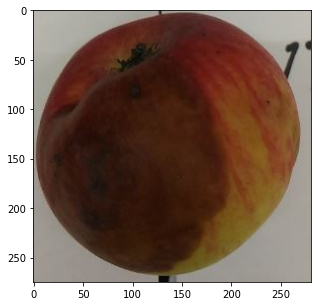

In [5]:
# apple = cv2.imread('Apples_examples/ImageSet_Aug_30_17_56_56.jpg')  # This is how you can write a pass in Jupyter Notebook
apple = cv2.imread('/content/gdrive/My Drive/Apples_examples/ImageSet_Aug_30_17_56_56.JPG')  # This is how you can write a pass in Google Colab  
apple = cv2.cvtColor(apple, cv2.COLOR_BGR2RGB)
plt.imshow(apple)
plt.show()

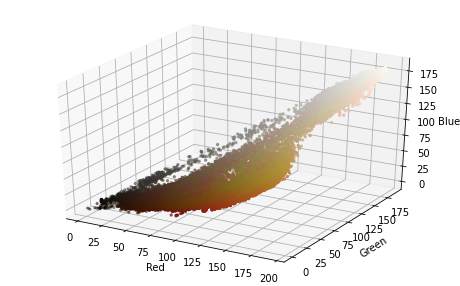

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

r, g, b = cv2.split(apple)  # RGB colour model
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = apple.reshape((np.shape(apple)[0]*np.shape(apple)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

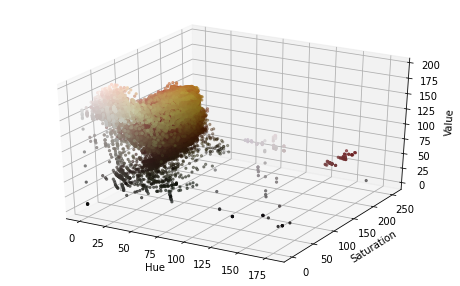

In [7]:
hsv_apple = cv2.cvtColor(apple, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_apple)  # HSV colour model
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

Let's try it on another image.

### Let's check colours!

We can also to convert HSV to RGB

In [8]:
from matplotlib.colors import hsv_to_rgb 

# Here is our function
def color_check(light, dark):
    rcParams['figure.figsize'] = 5, 2

    lg_square = np.full((10, 10, 3), light, dtype=np.uint8) / 255.0
    dg_square = np.full((10, 10, 3), dark, dtype=np.uint8) / 255.0

    ## print(lg_square, dg_square)

    plt.subplot(1, 2, 1)
    plt.imshow(hsv_to_rgb(dg_square))
    plt.subplot(1, 2, 2)
    plt.imshow(hsv_to_rgb(lg_square))
    plt.show()

In [9]:
# Now we need to select colours coordinates.

dark_green = (95, 255, 255)
light_green = (1, 40, 80)

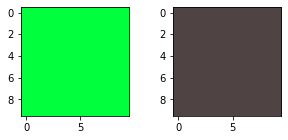

In [10]:
color_check(light_green, dark_green) 

## Now we can create a mask


In [16]:
# Our function which shows the our segmentation masks. 
def show_result(mask, result, apple):
    rcParams['figure.figsize'] = 15, 5
    plt.subplot(1, 3, 1)
    plt.imshow(mask, cmap="gray")
    plt.subplot(1, 3, 2)
    plt.imshow(result)
    plt.subplot(1, 3, 3)
    plt.imshow(apple)
    plt.show()

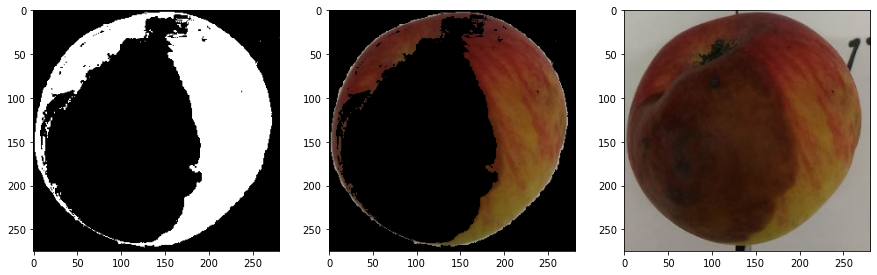

In [17]:
mask = cv2.inRange(hsv_apple, light_green, dark_green)
result_rect = cv2.bitwise_and(apple, apple, mask=mask)
show_result(mask, result_rect, apple)

In [18]:
rect_area = cv2.countNonZero(cv2.cvtColor(result_rect, cv2.COLOR_RGB2GRAY))
print(rect_area)

24154


In [19]:
def count_pix(apple, hsv_apple, rect_area, show, verbose):
  
    mask_green = cv2.inRange(hsv_apple, light_green, dark_green)
  
    result = cv2.bitwise_and(apple, apple, mask=mask_green)
  
    res_gray = cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)

    area_cm2 = cv2.countNonZero(res_gray)/rect_area
    
    if verbose:
        print('Apple area in pixels:', cv2.countNonZero(res_gray))
        print('Apple area in cm2:', area_cm2)
    if show:
        show_result(mask_green, result, apple)
    return cv2.countNonZero(res_gray), area_cm2

Apple area in pixels: 24154
Apple area in cm2: 1.0


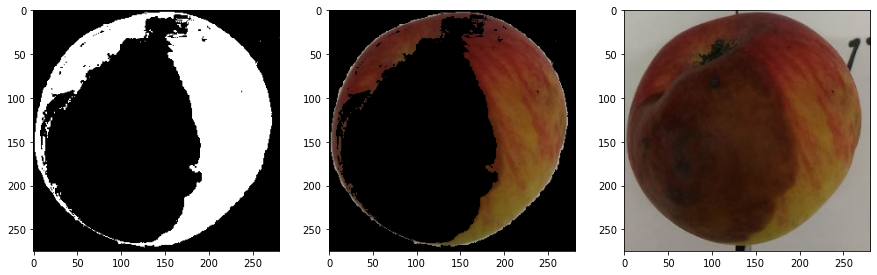

(24154, 1.0)

In [20]:
count_pix(apple, hsv_apple, rect_area, show=True, verbose=True)

## Pixel counting on a group of images

In [21]:
def make_hsv_apple(name):
    apple = cv2.imread(name)
    apple = cv2.cvtColor(apple, cv2.COLOR_BGR2RGB)
    r, g, b = cv2.split(apple)
    
    pixel_colors = apple.reshape((np.shape(apple)[0]*np.shape(apple)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()
    hsv_apple = cv2.cvtColor(apple, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_apple)
    return apple, hsv_apple

In [22]:
root = '/content/gdrive/My Drive/Apples_examples'
#september = []
#october = []
apples = []
import os
import pandas as pd
from IPython import display
for name in sorted(os.listdir(root)):
    if name.split('_')[1] == 'Aug':
        apples.append(name)
    #else:
        #october.append(name)

In [23]:
apples

['ImageSet_Aug_26_13_56_48.JPG',
 'ImageSet_Aug_26_15_14_07.JPG',
 'ImageSet_Aug_26_16_01_05.JPG',
 'ImageSet_Aug_26_16_50_35.JPG',
 'ImageSet_Aug_26_18_33_07.JPG',
 'ImageSet_Aug_27_10_52_09.JPG',
 'ImageSet_Aug_27_12_27_38.JPG',
 'ImageSet_Aug_27_15_10_25.JPG',
 'ImageSet_Aug_27_17_08_52.JPG',
 'ImageSet_Aug_28_11_14_10.JPG',
 'ImageSet_Aug_28_12_57_42.JPG',
 'ImageSet_Aug_28_15_07_29.JPG',
 'ImageSet_Aug_28_16_57_52.JPG',
 'ImageSet_Aug_29_13_31_32.JPG',
 'ImageSet_Aug_29_15_29_18.JPG',
 'ImageSet_Aug_29_17_25_33.JPG',
 'ImageSet_Aug_30_13_37_04.JPG',
 'ImageSet_Aug_30_14_58_37.JPG',
 'ImageSet_Aug_30_17_56_56.JPG']

In [24]:
apples[-3:]

['ImageSet_Aug_30_13_37_04.JPG',
 'ImageSet_Aug_30_14_58_37.JPG',
 'ImageSet_Aug_30_17_56_56.JPG']

In [25]:
apples[:3]

['ImageSet_Aug_26_13_56_48.JPG',
 'ImageSet_Aug_26_15_14_07.JPG',
 'ImageSet_Aug_26_16_01_05.JPG']

Apple area in pixels: 41477
Apple area in cm2: 1.717189699428666


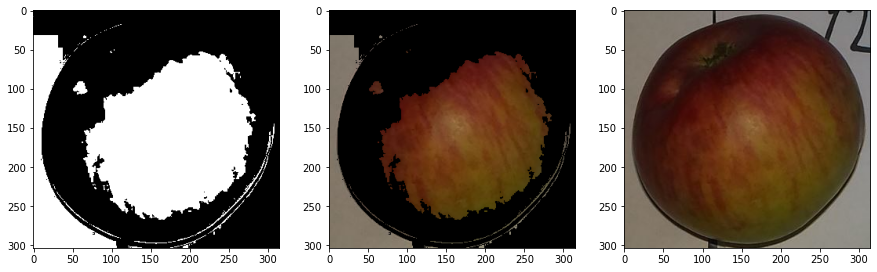

In [26]:
pix_squares_apples = []
cm2_squares_apples = []
for i, name in enumerate(apples):
    a, b = make_hsv_apple('/content/gdrive/My Drive/Apples_examples/'+name)
    if i%30 == 0:
        display.clear_output(wait=True)
        c, d = count_pix(a, b, rect_area, show=True, verbose=True)
    else:
        c, d = count_pix(a, b, rect_area, show=False, verbose=False)
    pix_squares_apples.append(c)
    cm2_squares_apples.append(d)

In [27]:
months = []
days = []
hours = []
minutes = []
names = apples
for name in names:
    fig = name.split('_')
    month, day, hour, minute = fig[1:5]
    months.append(month)
    days.append(day)
    hours.append(hour)
    minutes.append(minute)

In [28]:
Apple_zone = pd.DataFrame(data = {'Pixel square': pix_squares_apples,
                                        'Cm2 square':cm2_squares_apples, 
                                        'Month':months,
                                        'Day': days,
                                        'Hours': hours,
                                        'Minutes' : minutes})

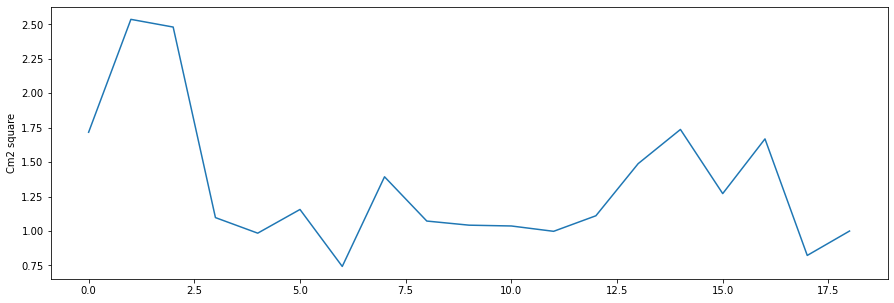

In [29]:
plt.plot(Apple_zone['Cm2 square'])
plt.ylabel('Cm2 square')
plt.show()

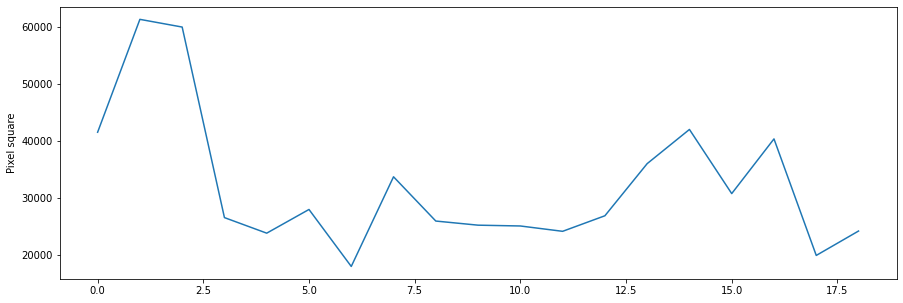

In [30]:
plt.plot(Apple_zone['Pixel square'])
plt.ylabel('Pixel square')
plt.show()

## Let's try to work not with apples, but with decay areas in apples

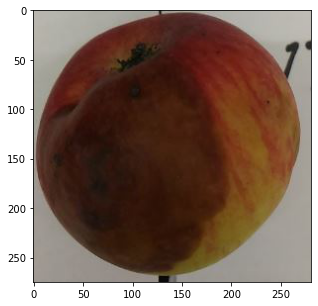

In [ ]:
decay = cv2.imread('Apples_examples/ImageSet_Aug_30_17_56_56.jpg')  # Open our image with apple once again. 
decay = cv2.cvtColor(decay, cv2.COLOR_BGR2RGB)
plt.imshow(decay)
plt.show()

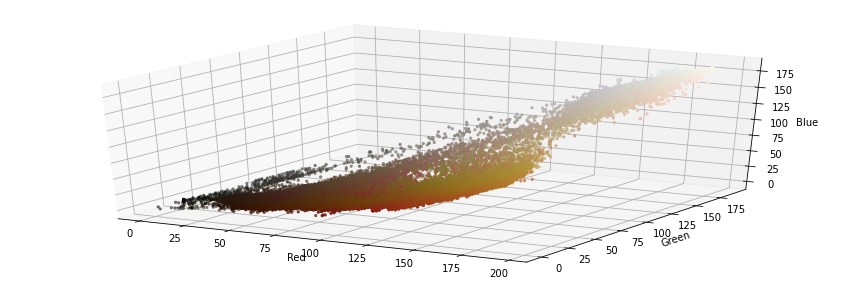

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import colors

r, g, b = cv2.split(decay)  # RGB colour space
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

pixel_colors = decay.reshape((np.shape(decay)[0]*np.shape(decay)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()

axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Red")
axis.set_ylabel("Green")
axis.set_zlabel("Blue")
plt.show()

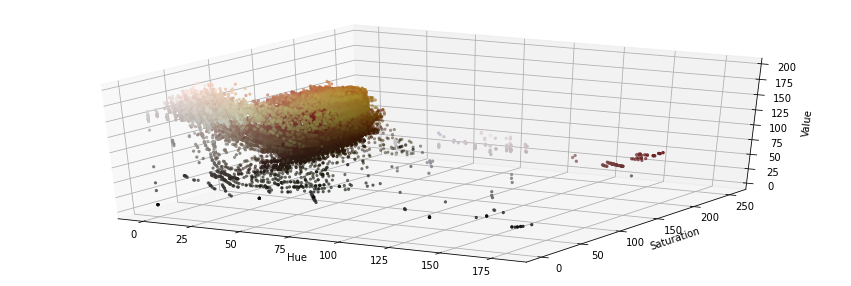

In [ ]:
hsv_decay = cv2.cvtColor(decay, cv2.COLOR_RGB2HSV)
h, s, v = cv2.split(hsv_decay)  # HSV space (I can also add a Link here)
fig = plt.figure()
axis = fig.add_subplot(1, 1, 1, projection="3d")

axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
axis.set_xlabel("Hue")
axis.set_ylabel("Saturation")
axis.set_zlabel("Value")
plt.show()

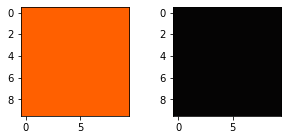

In [ ]:
# dark_green = (95, 255, 255)  BGR? 
# light_green = (1, 40, 80)

# dark_orange = (35, 255, 255)
# light_orange = (1, 200, 180)

# dark_red = (255, 255, 255)
# light_red = (170, 10, 5)

dark_brown = (16, 255, 255)
light_brown = (10, 10, 5)

color_check(light_brown, dark_brown)

In [ ]:
def show_result(mask, result, decay):
    rcParams['figure.figsize'] = 15, 5
    plt.subplot(1, 3, 1)
    plt.imshow(mask, cmap="gray")
    plt.subplot(1, 3, 2)
    plt.imshow(result)
    plt.subplot(1, 3, 3)
    plt.imshow(decay)
    plt.show()

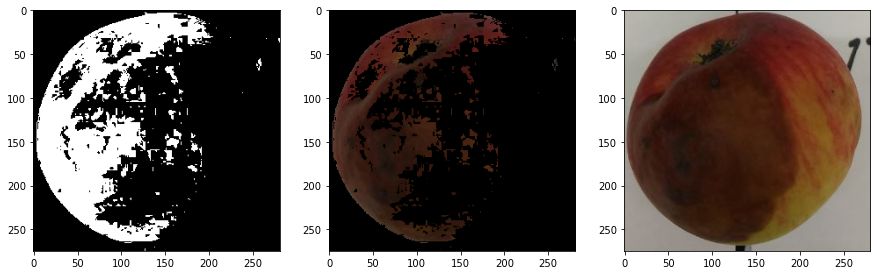

In [ ]:
mask = cv2.inRange(hsv_decay, light_brown, dark_brown)
result_rect = cv2.bitwise_and(decay, decay, mask=mask)
show_result(mask, result_rect, decay)

In [ ]:
def make_hsv_decay(name):
    decay = cv2.imread(name)
    decay = cv2.cvtColor(decay, cv2.COLOR_BGR2RGB)
    r, g, b = cv2.split(decay)
    
    pixel_colors = decay.reshape((np.shape(decay)[0]*np.shape(decay)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()
    hsv_decay = cv2.cvtColor(decay, cv2.COLOR_RGB2HSV)
    h, s, v = cv2.split(hsv_decay)
    return decay, hsv_decay

In [ ]:
root = 'Apples_examples'
#september = []
#october = []
decay = []
import os
import pandas as pd
from IPython import display
for name in sorted(os.listdir(root)):
    if name.split('_')[1] == 'Aug':
        decay.append(name)
    #else:
        #october.append(name)

Apple area in pixels: 41468
Apple area in cm2: 1.7218070088025246


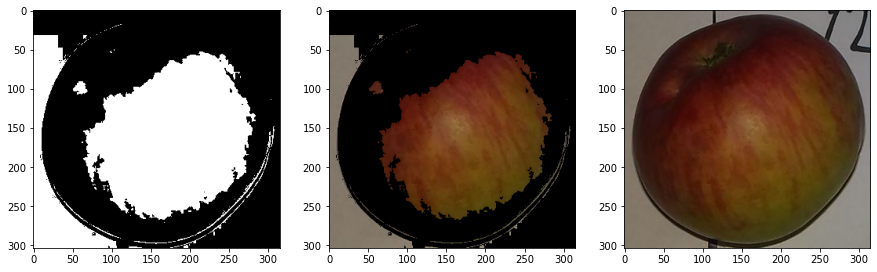

In [ ]:
pix_squares_decay = []
cm2_squares_decay = []
for i, name in enumerate(decay):
    a, b = make_hsv_decay('Apples_examples/'+name)
    if i%30 == 0:
        display.clear_output(wait=True)
        c, d = count_pix(a, b, rect_area, show=True, verbose=True)
    else:
        c, d = count_pix(a, b, rect_area, show=False, verbose=False)
    pix_squares_decay.append(c)
    cm2_squares_decay.append(d)

In [ ]:
months = []
days = []
hours = []
minutes = []
names = decay
for name in names:
    fig = name.split('_')
    month, day, hour, minute = fig[1:5]
    months.append(month)
    days.append(day)
    hours.append(hour)
    minutes.append(minute)

In [ ]:
Decay_zone = pd.DataFrame(data = {'Pixel square': pix_squares_decay,
                                        'Cm2 square':cm2_squares_decay, 
                                        'Month':months,
                                        'Day': days,
                                        'Hours': hours,
                                        'Minutes' : minutes})

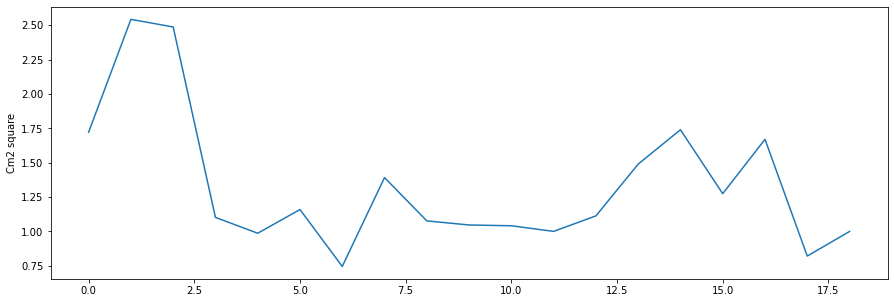

In [ ]:
plt.plot(Decay_zone['Cm2 square'])
plt.ylabel('Cm2 square')
plt.show()

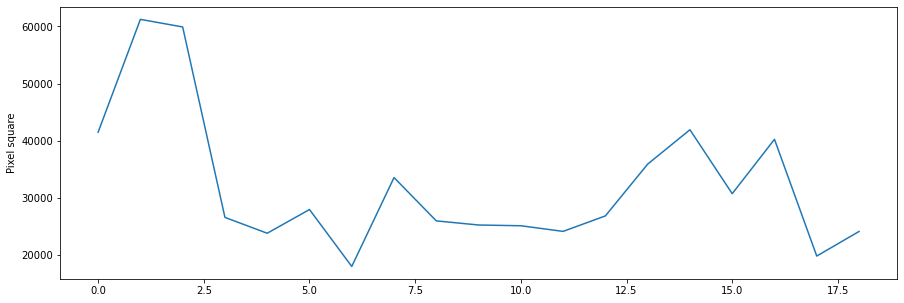

In [ ]:
plt.plot(Decay_zone['Pixel square'])
plt.ylabel('Pixel square')
plt.show()